In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, merge
from keras.models import Model, Sequential
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import accuracy_score

%matplotlib inline

Using TensorFlow backend.


In [3]:
data = fetch_olivetti_faces()

In [4]:
images = [np.repeat(data.images[i][:,:,np.newaxis],3,axis=2) for i in range(len(data.images))]

In [5]:
input_shape = images[0].shape
anchor_input = Input(input_shape)
positive_input = Input(input_shape)
negative_input = Input(input_shape)

In [6]:
model = VGG19(include_top=False, weights='imagenet',input_shape=input_shape)
for layer in model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
x = model.output
x = Flatten()(x)
x = Dense(1024,activation='sigmoid')(x)

In [8]:
model_final = Model(input=model.input, output=x)

/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [9]:
def triplet_loss(anchor, positive, negative, dist='euclidean', margin='maxplus'):
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

"\ndef triplet_loss(anchor, positive, negative, dist='euclidean', margin='maxplus'):\n    positive_distance = K.square(anchor - positive)\n    negative_distance = K.square(anchor - negative)\n    if dist == 'euclidean':\n        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))\n        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))\n    elif dist == 'sqeuclidean':\n        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)\n        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)\n    loss = positive_distance - negative_distance\n    if margin == 'maxplus':\n        loss = K.maximum(0.0, 1 + loss)\n    elif margin == 'softplus':\n        loss = K.log(1 + K.exp(loss))\n    return K.mean(loss)\n"

The below loss function is 

<img src="https://cdn-images-1.medium.com/max/1600/0*AX2TSZNk19_gDgTN.png" alt="drawing" width="400"/>

However, this loss function does not differentiate postive(negative) images if the difference is already below $\alpha$, as all the negative values are clipped to zero.

As suggested in https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24, we can implement alternative loss function

<img src="https://cdn-images-1.medium.com/max/1600/1*ImLyAlX_cky6AXjDzHdEjQ.png" alt="drawing" width="400"/>


In [10]:
ALPHA = .2

def triplet_loss(x):
    anchor, positive, negative = x

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)

    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), ALPHA)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)

    return loss

In [97]:
def triplet_loss(x, N = 400, epsilon=.00001):
    anchor, positive, negative = x
    beta = N
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),1)
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),1)
    
    #Non Linear Values  
    
    # -ln(-x/N+1)
    pos_dist = -tf.log(-tf.divide((pos_dist),beta)+1+epsilon)
    neg_dist = -tf.log(-tf.divide((N-neg_dist),beta)+1+epsilon)
    
    # compute loss
    loss = neg_dist + pos_dist

    return loss

In [98]:
anchor_embedding = model_final(anchor_input)
positive_embedding = model_final(positive_input)
negative_embedding = model_final(negative_input)

loss_layer = Lambda(lambda tensors:triplet_loss([tensors[0],tensors[1],tensors[2]]),output_shape=(1,)) #merge([anchor_embedding, positive_embedding, negative_embedding],mode=triplet_loss, output_shape=(1,))
loss = loss_layer([anchor_embedding,positive_embedding,negative_embedding])

triplet_model = Model(inputs=[anchor_input, positive_input, negative_input],
                  outputs=loss)

In [99]:
def identity_loss(ytrue, ypred):
    return K.mean(ypred - 0 * ytrue)

In [100]:
triplet_model.compile(loss='mean_absolute_error',optimizer=Adam())

In [101]:
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1024)         22122560    input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [102]:
classes = data.target

In [103]:
class Triplet_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, images, classes):
        self.data = images
        self.classes = np.unique(classes)
        self.class_image_id = dict(zip(self.classes,[np.argwhere(classes==i).reshape(1,-1)[0] for i in self.classes]))
        
    def get_batch(self,batch_size):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data
        n_examples = len(self.data)
        w, h, _  = input_shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(self.classes,size=(batch_size,2))
        
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,3)) for i in range(3)]

        for i in range(batch_size):
            category1, category2 = categories[i]
            idx_1 = rng.choice(self.class_image_id[category1])
            idx_2 = rng.choice(self.class_image_id[category1])
            idx_3 = rng.choice(self.class_image_id[category2])
            pairs[0][i,:,:,:] = self.data[idx_1]
            pairs[1][i,:,:,:] = self.data[idx_2]
            pairs[2][i,:,:,:] = self.data[idx_3]
                
        return pairs
    
    def generate(self, batch_size):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs = self.get_batch(batch_size)
            yield ({'input_1':pairs[0],'input_2':pairs[1],'input_3':pairs[2]}, np.zeros((batch_size,1)))
            

In [104]:
batch_size = 128
epochs = 2
steps_per_epoch = 10

In [105]:
train_count = 320
val_count = 40
test_count = len(images) - train_count - val_count

In [106]:
train_loader = Triplet_Loader(images[:train_count],classes[:train_count])
val_loader = Triplet_Loader(images[train_count:train_count+val_count],classes[train_count:train_count+val_count])

In [107]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=2)

In [108]:
triplet_model.fit_generator(train_loader.generate(batch_size),steps_per_epoch=steps_per_epoch,epochs=epochs,validation_data=val_loader.generate(val_count),validation_steps=1,callbacks=[early])


Epoch 1/2
10/10 [==============================] - 88s 9s/step - loss: 1.6681 - val_loss: 2.1661
Epoch 2/2
10/10 [==============================] - 82s 8s/step - loss: 1.3502 - val_loss: 1.2913


In [109]:
preds = triplet_model.predict_generator(val_loader.generate(val_count),steps=1)

In [111]:
train_pred = model_final.predict(np.array(images[:train_count+val_count]))
test_pred = model_final.predict(np.array(images[train_count+val_count:]))

In [112]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(test_pred)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=2, p=2, radius=1.0)

In [113]:
distances_test, neighbors_test = neigh.kneighbors(test_pred)

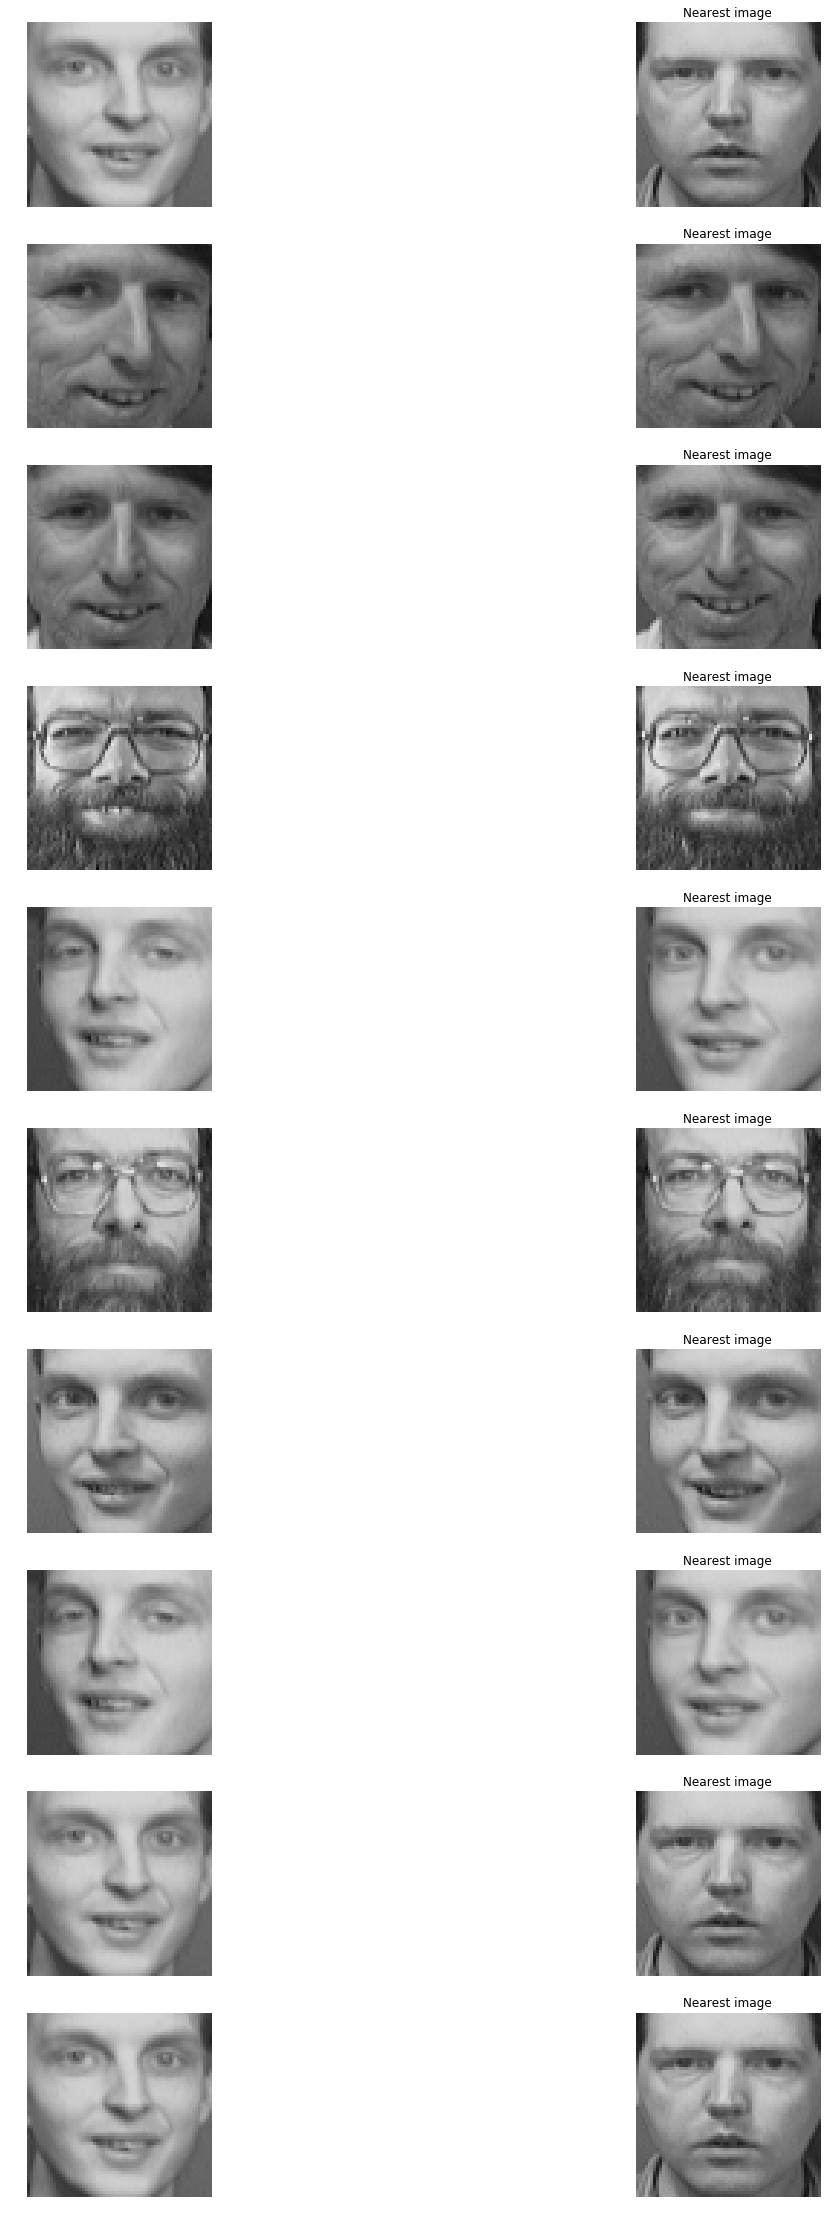

In [114]:
plt.figure(figsize=(20,40))
for i, row_num in enumerate(rng.choice(np.arange(40),10).tolist()):
    sub = plt.subplot(10,2,i*2+1)
    sub.axis("off")
    sub.imshow(images[train_count+val_count+row_num])
    
    sub = plt.subplot(10,2,i*2+2,title="Nearest image")
    sub.axis("off")
    sub.imshow(images[train_count+val_count+neighbors_test[row_num][1]]) 